### Function to make variables from wavelet decomposition

In [2]:
def make_dwt_vars(wells_df,logs,levels,wavelet='db3'):

    from scipy.interpolate import interp1d
    import pywt
    
    wave= pywt.Wavelet(wavelet)
    max_level = max(levels)
    
    grouped = wells_df.groupby(['Well Name'])
    new_df = pd.DataFrame()
    for key in grouped.groups.keys():
    
        depth = grouped.get_group(key)['Depth']
        temp_df = pd.DataFrame()
        temp_df['Depth'] = depth
        for log in logs:
      
            temp_data = grouped.get_group(key)[log]
        
            for i in range(1,max_level+1):

                cA,cD = pywt.dwt(temp_data,wave,mode='symmetric')
                new_depth = np.linspace(min(depth),max(depth),len(cD))
                f = interp1d(new_depth,cD,kind='nearest')
                
                if (i in levels):
                    temp_df[log + '_cD_step_level_' + str(i)] = f(depth)
    
        temp_df['Well Name'] = [key for _ in range(len(depth))]
        new_df = new_df.append(temp_df)
        
    new_df = new_df.sort_index()
    new_df = new_df.drop(['Well Name','Depth'],axis=1)
    return pd.concat([wells_df,new_df],axis=1)

In [3]:
def make_entropy_vars(wells_df,logs,l_foot):
    
    from skimage.filters.rank import entropy
    from skimage.morphology import rectangle
    from skimage.util import img_as_ubyte
    
    new_df = pd.DataFrame()
    grouped = wells_df.groupby(['Well Name'])
    
    for key in grouped.groups.keys():
    
        depth = grouped.get_group(key)['Depth']
        temp_df = pd.DataFrame()
        temp_df['Depth'] = depth
        
        for log in logs:
      
            temp_data = grouped.get_group(key)[log]       
            footprint = rectangle(l_foot,3)

            image = np.vstack((temp_data,temp_data,temp_data))
            image -= np.median(image) 
            image /= np.max(np.abs(image))
            image = img_as_ubyte(image)

            temp_df[log + '_entropy_foot' + str(l_foot)] = entropy(image,footprint)[0,:]
    
        temp_df['Well Name'] = [key for _ in range(len(depth))]
        new_df = new_df.append(temp_df)
    
    new_df = new_df.sort_index()
    new_df = new_df.drop(['Well Name','Depth'],axis=1)
    return pd.concat([wells_df,new_df],axis=1)

## Exploring the dataset
First, we will examine the data set we will use to train the classifier.

In [11]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

from pandas import set_option
set_option("display.max_rows", 10)
pd.options.mode.chained_assignment = None

filename = 'data/facies_vectors.csv'
training_data = pd.read_csv(filename)
training_data.describe()

,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,3232.000000,4149.000000,4149.000000
mean,4.503254,2906.867438,64.933985,0.659566,4.402484,13.201066,3.725014,1.518438,0.521852
std,2.474324,133.300164,30.302530,0.252703,5.274947,7.132846,0.896152,0.499720,0.286644
min,1.000000,2573.500000,10.149000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.000000
25%,2.000000,2821.500000,44.730000,0.498000,1.600000,8.500000,3.100000,1.000000,0.277000
50%,4.000000,2932.500000,64.990000,0.639000,4.300000,12.020000,3.551500,2.000000,0.528000
75%,6.000000,3007.000000,79.438000,0.822000,7.500000,16.050000,4.300000,2.000000,0.769000
max,9.000000,3138.000000,361.150000,1.800000,19.312000,84.400000,8.094000,2.000000,1.000000


### Choice of Variables
Here we use both functions to generate variable and then handpicked the ones to use.

logs = ['PHIND','ILD_log10','DeltaPHI']
levels = [4]

training_full = make_dwt_vars(training_data,['GR'],levels)
training_full = make_entropy_vars(training_full,logs,20)
training_full

In [42]:
training_full.replace(to_replace=np.nan,value=-99999,inplace=True)

In [43]:
from imblearn.over_sampling import SMOTE
from sklearn import preprocessing
from sklearn import svm
from sklearn import metrics
from sklearn import ensemble

## K fold cross-validation 

Doing a cross-validation on each well in order to see how the predictor works on each well as a blind dataset

In [44]:
estimators = [1,10,50,100,200,300,500,800,1000,2000,5000]
mean_F1 = []

for n in estimators:
    names = list(np.unique(training_full['Well Name']))
    grouped = training_full.groupby(['Well Name'])
    scores = []

    for name in names:

        test = grouped.get_group(name)
        X_test = test.drop(['Formation', 'Well Name', 'Depth','Facies'], axis=1).values
        y_test = test['Facies'].values

        train_names = names.copy()
        train_names.remove(name)
        train = pd.DataFrame()

        for train_name in train_names:
            train = train.append(grouped.get_group(train_name))

        X_train = train.drop(['Formation', 'Well Name', 'Depth','Facies'], axis=1).values
        y_train = train['Facies'].values

        #The prediction begins
        
        #We start with oversampling minority classes
        smt = SMOTE()
        X_train, y_train = smt.fit_sample(X_train,y_train)
        
        clf = ensemble.RandomForestClassifier(n_estimators=n,n_jobs=-1)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        #Scoring
        score = metrics.f1_score(y_test, y_pred, average='weighted')
        scores.append(score)
#         print('********')
#         print('Blind well is {0}, F1 score : {1:.4%}\n'.format(name,score))

#     print("="*30)
#     print('*********** RESULT ***********')
#     print("="*30)
#     print('\nAverage  F1-score is {:.4%}'.format(np.mean(scores)))

    mean_F1.append(np.mean(scores))

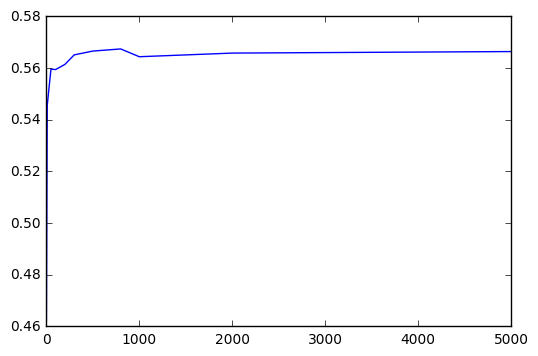

In [45]:
plt.plot(estimators,mean_F1);